In [1]:
# using CairoMakie
using Plots
using Interpolations
using WriteVTK
using FLoops

using MeshCat
using CoordinateTransformations
using Rotations
using GeometryBasics: HyperRectangle, Vec, Point, Mesh
using GeometryBasics: Point3f
using Colors: RGBA, RGB

In [2]:
vis = Visualizer()


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\garla\.julia\packages\MeshCat\oC0sL\src\visualizer.jl:73


MeshCat Visualizer with path /meshcat at http://127.0.0.1:8700

In [209]:
mutable struct Dot
    id::Int32
    
    x::Float32
    y::Float32
    
    dxcum::Float32
    dycum::Float32
    
    x_old::Float32
    y_old::Float32
    
    
    sector::Int32
    group::Int32
end


# mutable struct Dot2
#     x::Float32
#     y::Float32
    
    
#     sector::Int32
#     group::Int32
# end

In [210]:
# d = Dot(1,1,1,1,1,1,1)

In [211]:
function default_dot(id::Int, x::Float32, y::Float32)
    d = Dot(id,x,y,0,0,0,0,1,1)    
end
function default_dot(id::Int, x::Float64, y::Float64)
    default_dot(id,convert(Float32, x), convert(Float32, y))
end

default_dot (generic function with 2 methods)

In [212]:
npoints = 2_000
dots = Vector{Dot}(undef,npoints)
d = 5
for i in 1:npoints
    dots[i] = default_dot(i,(rand(Float32)-0.5)/d,(rand(Float32)-0.5)/d)
#    d.x = rand(Float32)
#    d.y = rand(Float32)    
end

In [213]:
dots[1:10]

10-element Vector{Dot}:
 Dot(1, 0.07185664f0, -0.04232981f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(2, 0.099742696f0, 0.056501914f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(3, 0.07023773f0, -0.08340361f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(4, -0.03781984f0, -0.06325152f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(5, 0.051211715f0, -0.098568715f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(6, 0.074114f0, 0.062034596f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(7, -0.06869596f0, 0.05599636f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(8, 0.07185026f0, 0.023852933f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(9, 0.04510094f0, 0.010697806f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(10, 0.04759278f0, -0.03820945f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)

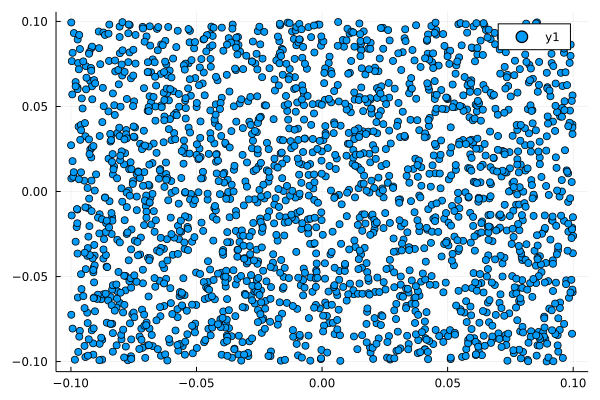

In [214]:
xs = [d.x for d in dots];
ys = [d.y for d in dots];

scatter(xs,ys)

In [215]:
 
# elementwise_f(f, v) = reduce((x, y) -> f.(x, y), v)
function min_e(constant_v)
   f  = function f(x)
        if typeof(x) == Float64
           x = [x] 
        end
        for i in range(1,size(x,1))
            x[i] = min(constant_v,x[i])
        end
        return x
    end
    return f
end

min_e (generic function with 1 method)

In [216]:
min10 = min_e(10)

(::var"#f#225"{Int64}) (generic function with 1 method)

In [217]:
# ?maximum 
# ? minimum
# ? min

In [218]:
# ?minimum

In [219]:
# x  = collect(1:20)
# min10(v)
#  for i in range(size(x,1))
#             x[i] = minumum(x,constant_v,x)
# end
# range(1,size(x,1))

In [220]:
# min_and_10 = elementwise_f(min, 10)

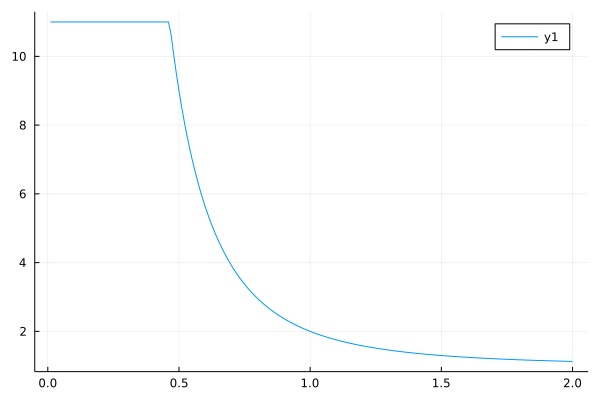

In [221]:
# rand(1:10,3)

min_distance = 0.02

x = 0.01:0.01:2
# y = log.(x)
y = 1 ./ x.^3
y = min10(y).+1
plot(x,y)

In [222]:
# y

In [223]:
function force(r)
#     m = 0.1
#    if r< min_distance
#         return min_distance*m
#     end
# #         return -interp(r)*m
# #     end
#     if r>1
#         return 0
#     end
#     y = -r/(-0.1+r)^2
    r = abs(r)
    y = 1 ./ r.^3
    y = min10(y).+1
   (r- r/y[1])
end

force (generic function with 1 method)

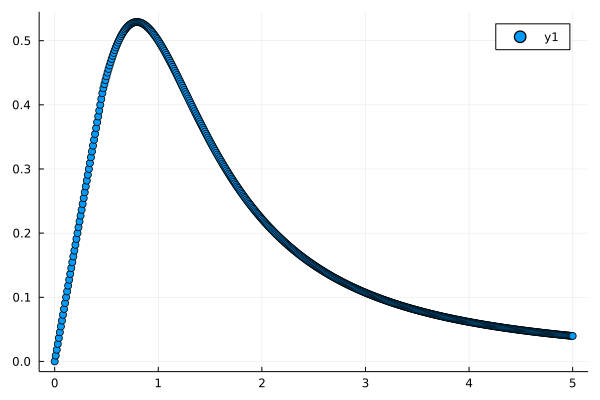

In [245]:
xs = 0:0.01:5;
ys = [force(z) for z in xs];

scatter(xs,ys)

In [225]:
d = 0.02
force(d)

0.01818181818181818

In [226]:
typeof(d)

Float64

In [227]:
function update_points!(p1::Dot, p2::Dot, temperature = 1e-1)
    dx = p2.x - p1.x + 1e-5
    dy = p2.y - p1.y
    d = (dx^2 + dy^2)^(1/2)
    θ = dx>0 ? atan(dy,dx) : atan(-dy,-dx) + π
    r = force(d)*temperature
#     if r <=0.00002
#         return
#     end
    y_mid = (p1.y+p2.y)/2
    x_mid = (p1.x+p2.x)/2
    
    # cum is cummulative. Add up all the movements before actually moving. 
    f = sin
    p1.dycum += f(θ)*r
    p2.dycum -= f(θ)*r      
    
    f = cos    
    p1.dxcum += f(θ)*r
    p2.dxcum -= f(θ)*r      
end

function move!(p1::Dot)
   p1.y +=p1.dycum
   p1.x +=p1.dxcum
    p1.dycum = 0
    p1.dxcum=0
end


function step!(dots, temperature = 1e-1)
#     pairs_to_select = 1000
#    idxs =  rand(1:npoints,pairs_to_select)
#    idxs2 =  rand(1:npoints,pairs_to_select)    
#     idxs = 1:npoints
#     idxs2 = reverse(1:npoints)    
#     for (i,j) in zip(idxs, idxs2)
#     for i in 1:npoints
    @floop for i in 1:npoints
        for j in i:npoints
            if i == j
                continue
            end
           update_points!(dots[i], dots[j], temperature)
        end
    end
    
    for i in 1:npoints
        move!(dots[i])
    end
end

step! (generic function with 2 methods)

In [228]:
# ?PointCloud

In [229]:
# ?Point3f 

In [230]:
n_points_track = npoints


2000

In [231]:
# ?Point3f

In [232]:
function update_cloud(dots, vis)
    xs = [d.x for d in dots[1:n_points_track]];
    ys = [d.y for d in dots[1:n_points_track]];
    zs = zeros(n_points_track);
#     Tt = transpose
    points = [Point3f(xv,yv,zv) for (xv,yv,zv) in zip(xs,ys,zs)]
    colors = [RGB(1.0f0,0.0f0,0.0f0) for _ in points]; # use the xyz value as rgb color
    
    pointcloud = PointCloud(points, colors );
    
    setobject!(vis[:pointcloud], pointcloud)
end


update_cloud (generic function with 1 method)

In [233]:
a = 1.0f0
typeof(a), a

(Float32, 1.0f0)

In [234]:
update_cloud(dots, vis)

MeshCat Visualizer with path /meshcat/pointcloud at http://127.0.0.1:8700

In [235]:
# dots = Vector{Dot}(undef,npoints)


In [236]:
n_steps =4
XS = zeros(Float32, n_points_track, n_steps)
YS = zeros(Float32, n_points_track, n_steps)
start_temp = 1
end_temp = 1e-1
for i in 1:n_steps
    
    xs = [d.x for d in dots[1:n_points_track]]
    ys = [d.y for d in dots[1:n_points_track]]
    
    XS[:,i] = xs
    YS[:,i] = ys
    
    temperature = -(start_temp-end_temp)/n_steps*i+start_temp
    
    step!(dots,temperature)
    
    i % 10 ==0 ? println("step $i, temperature = $temperature") : nothing
    update_cloud(dots, vis)
    
    
end

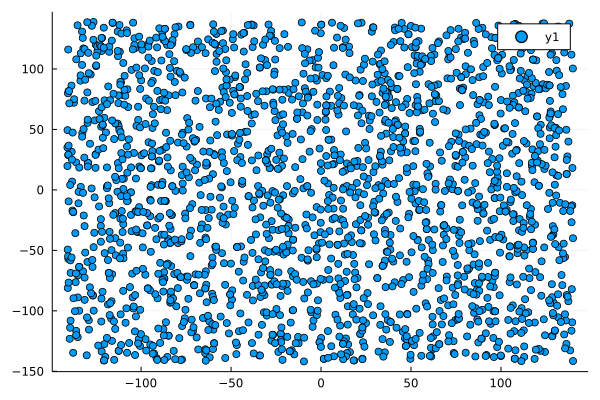

In [237]:
xs = [d.x for d in dots[1:n_points_track]];
ys = [d.y for d in dots[1:n_points_track]];

scatter(xs,ys)

In [238]:
# xs

In [239]:
# XS;

In [240]:
# p = rand(100, 100, 100)
# vtk_write_array("filename", p, "Pressure")
# vtk_write_array("filename", (XS, YS), ("x", "y"))

In [241]:
# add_dim(x::Array) = reshape(x, (size(x)...,1))

# using DelimitedFiles

# # ?writedlm

# # saved_files = paraview_collection("full_simulation") do pvd
# ids = collect(1:n_points_track)
# for i in 1:n_steps
#     #     for i in 1:5

#              xs = add_dim(XS[:,i] )
#              ys =  add_dim(YS[:,i] )

#     #         vtk_write_array("vtk/filename_$i", (xs, ys), ("x", "y"))        
#             points  = hcat(ids,xs,ys)
#     #         println(size(points))
#     #         vtk_write_array("vtk/filename_$i", (xs, ys), ("x", "y"))
#     #         vtk_write_array("vtk/filename_$i",points,"coords")        
#         writedlm( "vtk/points_$i.csv",  points, ',')
#     # writedlm( "vtk/YS.csv",  transpose(YS), ',')


#     #         vtk_grid("timestep_$n", x, y, z) do vtk
#     #             vtk["Pressure"] = rand(length(x), length(y), length(z))
#     #             pvd[time] = vtk
#     #         end
#     end
# # end

In [242]:

# writedlm( "vtk/XS.csv", transpose( XS), ',')
# writedlm( "vtk/YS.csv",  transpose(YS), ',')

In [243]:



# small = 1e-9

#         x1 = xs[i]#+small
#         x2 = xs[j]
#         y1 = ys[i]#+small
#         y2 = ys[j]
#         dx = x2 - x1
#         dy = y2 - y1
#         d = (dx.^2 + dy.^2).^(1/2)
# #         theta = atan.(dy./dx)
#         θ = dx>0 ? atan(dy,dx) : atan(-dy,-dx) + π
        
        
#         dy_dx = dy./dx
#         s = sin(θ)
#         c = cos(θ)
#         println("($x1,$y1) and ($x2, $y2)\t with theta $θ and d = $d. s,c = ($s,$c)")
#     end
# end


In [244]:
# xss = [-1, 1, 1, -1] ./4
# yss = [-1, -1, 1, 1] ./4

# xss = xss[1:2]
# yss = yss[1:2]


# dots = []
# for (xs,ys) in zip(xss,yss)
#    d = default_dot(1,xs,ys)
#     push!(dots, d)
# end

# temperature=1
# for i in 1:size(dots,1)
#     j = 1
# #     for j in 1:4
#         if i == j; continue ;end
#            update_points!(dots[i], dots[j], temperature)
        
# #     end
# end

# function move_points!(dots)
#     for d in dots
#         d.x_old = d.x
#         d.y_old = d.y
        
#         d.x = d.x+d.dxcum
#         d.y = d.y+d.dycum
        
#         d.dxcum = 0
#         d.dycum = 0
#     end
# end

# move_points!(dots)

# x1s = [d.x_old for d in dots]
# y1s = [d.y_old for d in dots]

# x2s = [d.x for d in dots]
# y2s = [d.y for d in dots]

# scatter(x1s,y1s, label = "start")
# p = scatter!(x2s,y2s, label = "end")
# for i in 1:1
#     p =plot!([x1s[i],x2s[i]], [y1s[i], y2s[i]])
# end
# p
# xaxis!(lims = [-1,1])
# yaxis!(lims = [-1,1])